In [1]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import gaussian_kde, linregress
from scipy import stats
import matplotlib.patches as mpatches

sys.path.insert(1, '../')
# from SeasonalPlot_Functions import *

from MasterPlot_Functions import *
from FormatEvents_Functions import *

import cmasher as cmr
import matplotlib as mpl

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest                   
cmap = mpl.colormaps['cmr.seaweed']  

In [2]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [3]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Load and prepare data

#### All events data

In [15]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics_new.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)
# df_long = df_long[~df_long['filename'].str.contains("part1", case=False)]

present_all_events=df_long[df_long['Climate']=='Present'].copy()
future_all_events =df_long[df_long['Climate']=='Future'].copy()
# nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

In [5]:
print(len(present_all_events))
print(len(future_all_events))

1034950
1020443


#### Change data

In [6]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents_new.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents_new.csv")
df_changes_byduration = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur_new.csv")
df_changes_byduration_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydur_new.csv")

#### Seasonal splits

In [7]:
df_changes_summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
df_changes_byduration_summer = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

df_changes_winter = df_changes_all_season[df_changes_all_season['season']=='Winter']
df_changes_byduration_winter = df_changes_byduration_season[df_changes_byduration_season['season']=='Winter']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# Storm characteristics

In [8]:
# present_all_events = present_all_events[present_all_events['max_intensity']>1]
# future_all_events = future_all_events[future_all_events['max_intensity']>1]

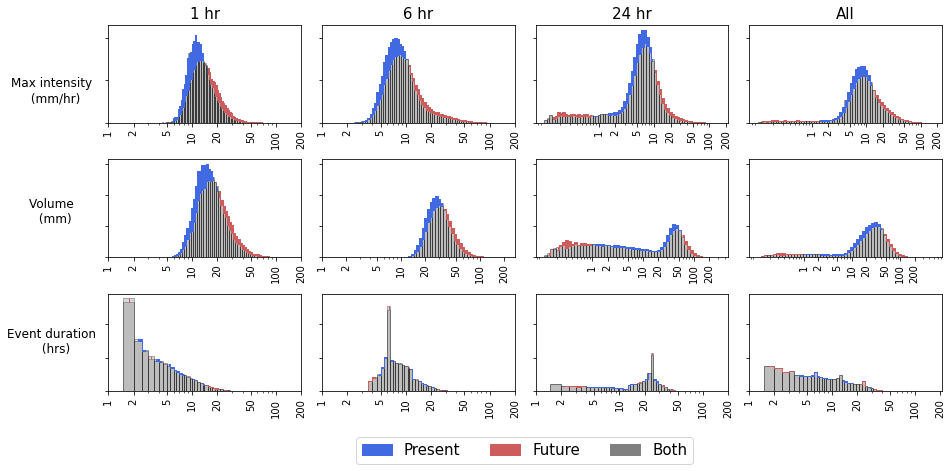

In [9]:
bin_edges_intensity = np.arange(0, 70 + 5, 2)
bin_edges_volume = np.arange(0, 135 + 5, 3)
bin_edges_duration = np.arange(0, 165 + 5,1)

durations = ['1', '6', '24']
alpha = 1
# Create a figure with subplots for different durations
n_categories = len(durations)
n_variables = 3
fig, axs = plt.subplots(n_categories, n_variables+1, figsize=(12, 2 * n_categories),  sharey='row')  

# Call the function for each variable in each duration category
for i, duration in enumerate(durations):
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='max_intensity', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[0,i], bins=70, alpha=alpha)
    
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='Volume', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[1,i], bins=60, alpha=alpha)   
    
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='duration', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[2,i], bins=60, alpha=alpha)       

    # Set x-axis labels for the last row
    #axs[2,0].set_xlabel("Event duration (hrs)", fontsize=10)
    #axs[2,1].set_xlabel("Event duration (hrs)", fontsize=10)
    #axs[2,2].set_xlabel("Event duration (hrs)", fontsize=10)
    #axs[2,3].set_xlabel("Event duration (hrs)", fontsize=10)    
        
    axs[0,0].set_title("1 hr", fontsize=15)
    axs[0,1].set_title("6 hr", fontsize=15)
    axs[0,2].set_title("24 hr", fontsize=15)
    axs[0,3].set_title("All", fontsize=15)
    
    # axs[0,3].legend(loc='upper right')

for ax in axs.flat:
    ax.set_yticklabels([])
    ax.set_ylabel("")

# Add the all data    
plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='max_intensity', 
    ax=axs[0,3], bins=70, alpha=alpha)       

plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='Volume', 
     ax=axs[1,3], bins=60, alpha=alpha)       

plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='duration', 
     ax=axs[2,3], bins=60, alpha=alpha)       

## Add legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='grey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.1],
           fontsize=15, ncol=4);

fig.text(-0.045, 0.78, 'Max intensity \n (mm/hr)', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.50, 'Volume \n (mm)', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.20, 'Event duration \n (hrs)', va='center', ha='center', fontsize=12, rotation='horizontal');

# Adjust layout to prevent overlap
plt.tight_layout()

# Seasonality of events
## Compare seasonal distribution for different durations AND between present and future

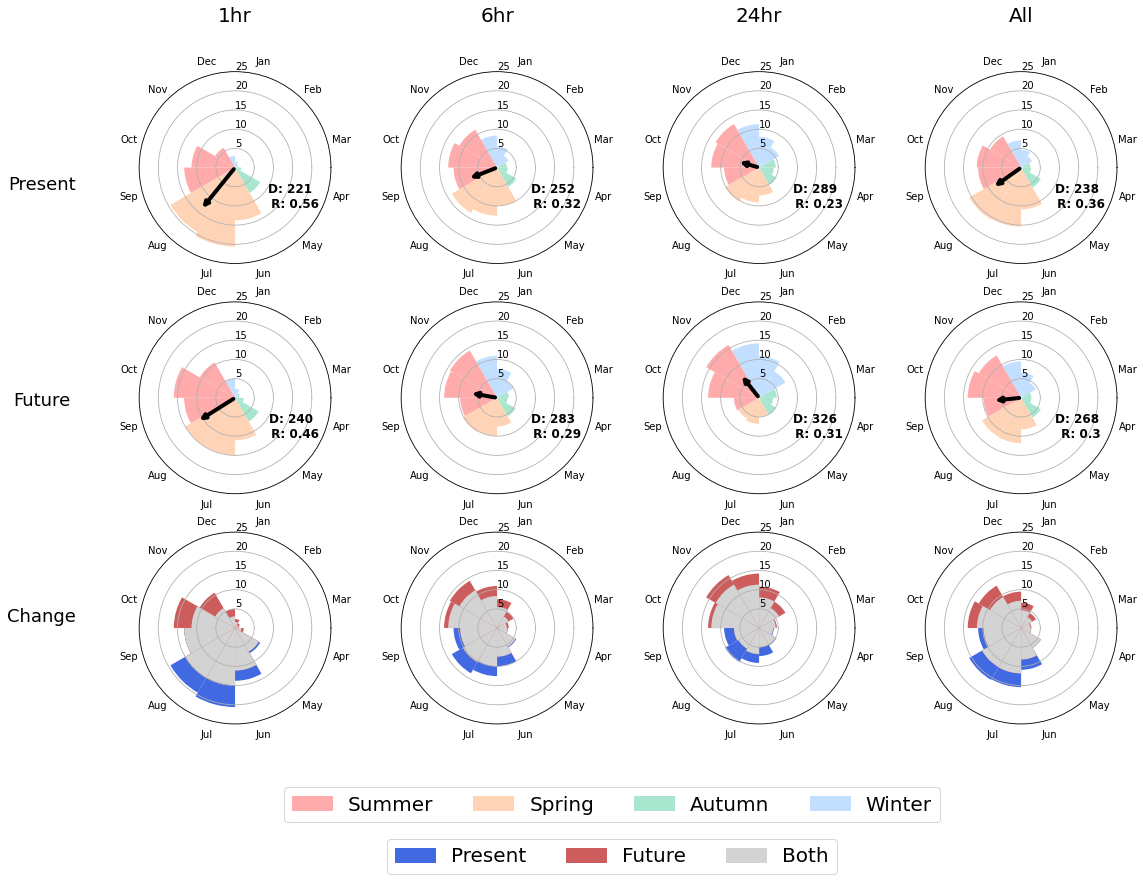

In [10]:
# List of durations and corresponding subplot titles
durations = ['1',  '6', "24"] # ['0.5', '1', '2', '3', '6',"12", '24']
titles = [f"{i}hr" for i in durations]

##########################################################
## present
##########################################################
fig, axes = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'polar': True})

# Loop through durations, axes, and titles
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = present_all_events[present_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    D_mean, R = calc_mean_day_and_dispersion(this_duration['theta'])
    plot_polar_months_plot(this_duration, axes[0, ax_num], True, title, 25, 'Percentage', D_mean, R)
D_mean, R = calc_mean_day_and_dispersion(present_all_events['theta'])    
plot_polar_months_plot(present_all_events, axes[0, 3], True, "All",25, 'Percentage', D_mean, R)    
fig.text(0.06, 0.75, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');

##########################################################
## Future
##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = future_all_events[future_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    D_mean, R = calc_mean_day_and_dispersion(this_duration['theta'])
    plot_polar_months_plot(this_duration, axes[1,ax_num], False, title, 25, 'Percentage', D_mean, R)
D_mean, R = calc_mean_day_and_dispersion(future_all_events['theta'])    
plot_polar_months_plot(future_all_events, axes[1,3], False, "Present (all)",25,  'Percentage', D_mean, R)    
fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');

# ##########################################################
# ## Present and future overlaid
# ##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration_pres = present_all_events[present_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    this_duration_future = future_all_events[future_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot_overlay(this_duration_pres, this_duration_future, axes[2, ax_num], False, 'All', False, 25) 
plot_polar_months_plot_overlay(present_all_events, future_all_events, axes[2, 3], False, 'All', False, 25) 
fig.text(0.06, 0.25, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');

## Create legend
winter_patch = mpatches.Patch(color='#C2DFFF', label='Winter')
autumn_patch = mpatches.Patch(color='#A8E6CF', label='Autumn')
spring_patch = mpatches.Patch(color='#FFD3B6', label='Spring')
summer_patch = mpatches.Patch(color='#FFABAB', label='Summer')

fig.legend(handles=[summer_patch, spring_patch, autumn_patch, winter_patch], loc = 'lower center', bbox_to_anchor=[0.5, 0],
           fontsize=20, ncol=4);

## Create legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='lightgrey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.06],
           fontsize=20, ncol=4);

## Day of year and R values 
For each gauge we can calculate:  
    - The mean day of year that events occur  
    - The R value of events - a measure of how dispersed/concentrated events are within a year  

### Histogram of the days of year for 24h, before 

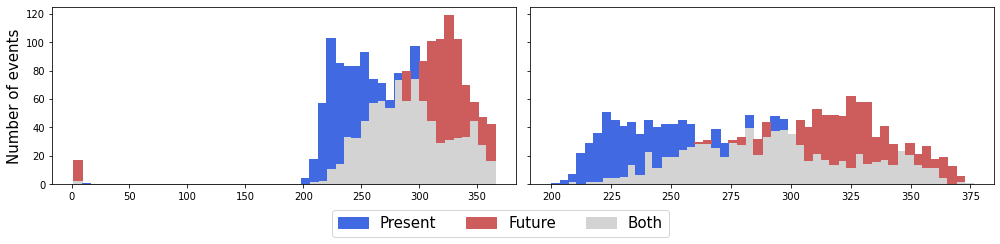

In [11]:
# Select data for a specific duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)].copy()

fig, axs = plt.subplots(ncols=2, figsize=(14, 3), sharey=True)

bins=50
# Plot histograms for both columns with overlap regions
plot_hist_with_overlap_shading(axs[0], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')

# Adjust for the second plot
this_duration["D_mean_present"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
this_duration["D_mean_future"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)

plot_hist_with_overlap_shading(axs[1], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')
axs[0].set_ylabel('Number of events', fontsize=15)

## Add legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='lightgrey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.15],
           fontsize=15, ncol=4);

plt.tight_layout()

### Day of year - present, future, change

In [14]:
D_diffs, D_diffs_dict = find_significance_of_differences(present_all_events, future_all_events, 'D')

In [15]:
D50_diffs, D50_diffs_dict =find_significance_of_differences(present_all_events, future_all_events, 'D50_new')
# R_diffs, R_diffs_dict = find_significance_of_differences(present_all_events, future_all_events, 'R')

In [16]:
# b2_diffs, b2_diffs_dict =find_significance_of_differences(present, future, 'B2_percentage')

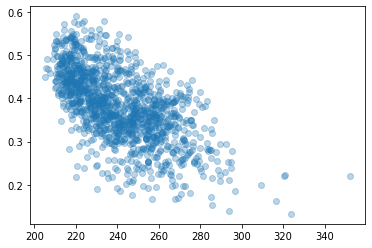

In [17]:
plt.scatter(df_changes_all['D_mean_present'],df_changes_all['R_present'], alpha=0.3)
# plt.scatter(df_changes_all['D_mean_future'],df_changes_all['R_future'], alpha=0.3)

In [18]:
# fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True, sharex=True)
# axs[0].scatter(df_changes_all['D_mean_present'],df_changes_all['R_present'])
# axs[1].scatter(df_changes_all['D_mean_future'],df_changes_all['R_future'])

In [19]:
# make_plot_D(df_changes_all, df_changes_byduration, 'D_mean','Blues', D_diffs_dict )

In [20]:
# # Call the function to plot the circular colorbar
# plot_circular_colorbar(colors, month_labels)

In [21]:
# duration=24
# this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num',  'D_mean_present', 'D_mean_future']]
# this_duration["D_mean_present_fixed"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 15 else x)
# this_duration["D_mean_future_fixed"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 15 else x)
    
# print("Present")
# print(this_duration['D_mean_present_fixed'].min())
# print(this_duration['D_mean_present_fixed'].max())

# print("Future")
# print(this_duration['D_mean_future_fixed'].min())
# print(this_duration['D_mean_future_fixed'].max())

In [12]:
# make_plot_D_seasonal(df_changes_all, df_changes_byduration, 'D_mean', D_diffs_dict )

###  R (how dispersed events are) - present, future change

In [ ]:
make_plot(df_changes_all, df_changes_byduration, 'R', 'inferno', D_diffs_dict)

# Loading analysis

In [ ]:
# h1 = df_changes_byduration[df_changes_byduration['sampling_duration']==24]
# # plt.scatter(h1['D50_mean_present'], h1['duration_mean_present'])
# # plt.scatter(h1['D50_mean_future'], h1['duration_mean_future'])
# plt.scatter(h1['D_mean_present'], h1['duration_mean_present'])
# plt.scatter(h1['D_mean_future'], h1['duration_mean_future'])

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'duration_mean', 'RdYlGn', D50_diffs_dict, 14, 33) 

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'duration_mean', 'RdYlGn', D50_diffs_dict, 3, 17) 

In [41]:

def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, norm, cmap='viridis'):
    gauge_locs = data['gauge_num'].copy()
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']

    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)

    # Scatter plot for the specified value column
    scatter = ax.scatter(
        lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=1, s=10, marker='o',
         norm=norm
    )
    if 'present' in value_column:
        ax.set_title(title, fontsize=20)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    return scatter
    



from matplotlib.colors import PowerNorm

    
def make_plot(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    print(np.unique(diffs_dict['All'],return_counts=True))
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    #################################################
    # Determine Color Limits Based on Both Datasets
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())
        # low_lim = 45.5

        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                      df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())   
        # high_lim=54.5

    #################################################
    # Plot Present Data for Each Duration
    #################################################
    # Apply PowerNorm for non-linear scaling
    nonlinear_norm = PowerNorm(gamma=0.5, vmin=low_lim, vmax=high_lim)

    # Use this normalization for present and future plots
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)]
        scatter = plot_values_on_map(
            axes[0, i], this_duration, f'{duration}h', tbo_vals, variable_present,
            low_lim, high_lim, nonlinear_norm, cmap  # Pass non-linear norm
        )
    # Plot 'All' present values
    scatter = plot_values_on_map(axes[0, 3], df_changes_all, 'All', tbo_vals, 
                                 variable_present, low_lim, high_lim,nonlinear_norm,  cmap)
    
    cbar_ax = fig.add_axes([1.005, 0.685, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)]
        scatter = plot_values_on_map(
            axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future,
            low_lim, high_lim, nonlinear_norm, cmap  # Pass non-linear norm
        )
    # Plot 'All' present values
    scatter = plot_values_on_map(axes[1, 3], df_changes_all, 'All', tbo_vals, 
                                 variable_future, low_lim, high_lim, nonlinear_norm,  cmap)    
    cbar_ax = fig.add_axes([1.005, 0.368, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    #################################################
    # Plot Difference Data if Available
    #################################################
    variable_diff = f'{variable}_diff'

    # Calculate and apply color limits centered around 0 for the difference
    low_lim_diff = -max(abs(df_changes_all[variable_diff].min()), abs(df_changes_all[variable_diff].max()),
                        abs(df_changes_byduration[variable_diff].min()), abs(df_changes_byduration[variable_diff].max()))
    low_lim_diff=-6
    high_lim_diff = -low_lim_diff

    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_diff']]
        this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        this_duration['sig'] =diffs_dict[duration] 
        scatter = plot_values_on_map_withsig(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff',
                                             low_lim_diff, high_lim_diff, 'bwr')
    
    # Plot 'All' differences
    scatter = plot_values_on_map_withsig(axes[2, 3], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals,
                                         variable_diff, low_lim_diff, high_lim_diff, 'bwr')    
    
    # Create the colorbar in this new axis
    cbar_ax = fig.add_axes([1.007, 0.054, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16) 
    if 'percentage' in variable:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.05)
    
    plt.tight_layout()    

(array([0, 1]), array([1126,  165]))


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


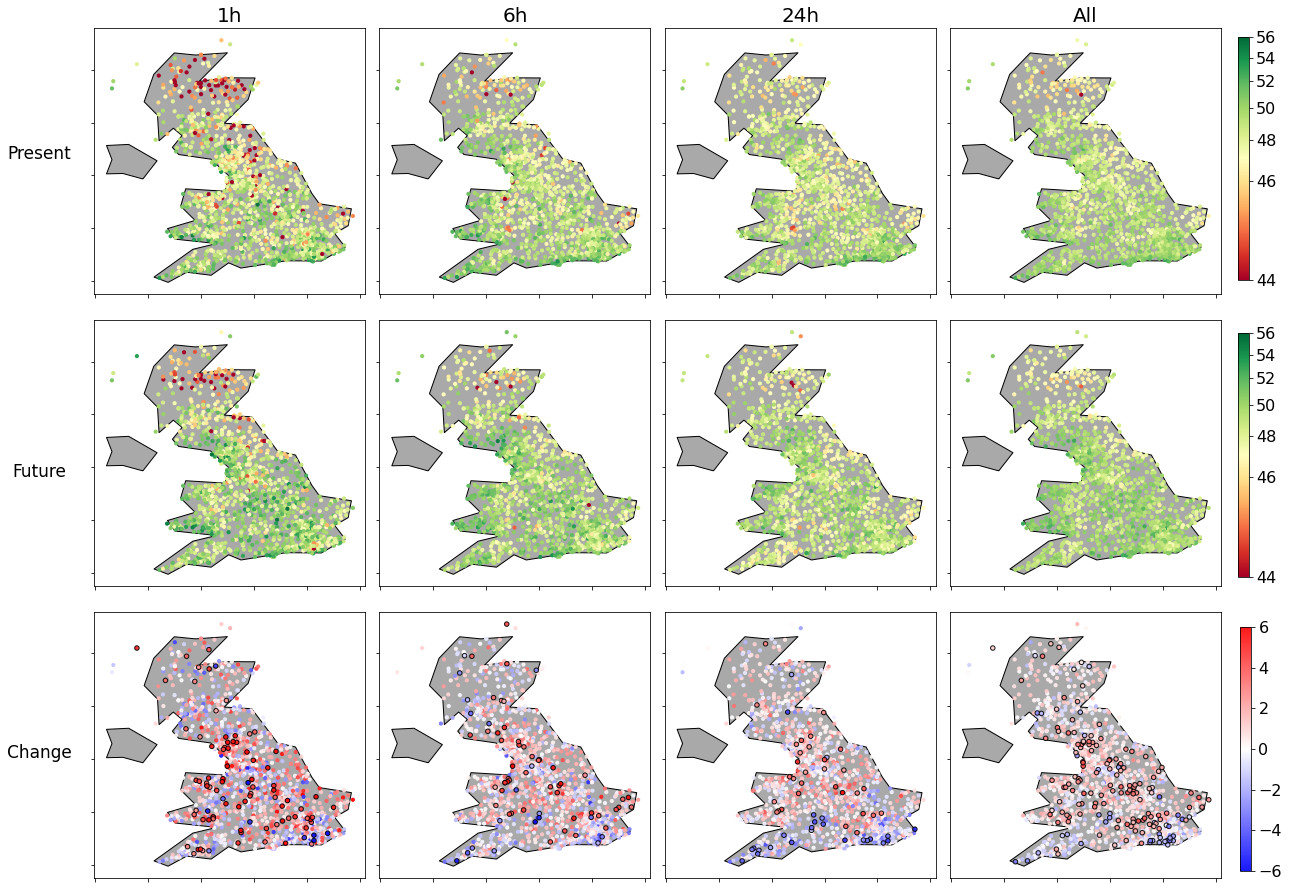

In [42]:
make_plot(df_changes_all, df_changes_byduration, 'D50_mean', 'RdYlGn', D50_diffs_dict, 44, 56) 

(array([0, 1]), array([1114,  177]))


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


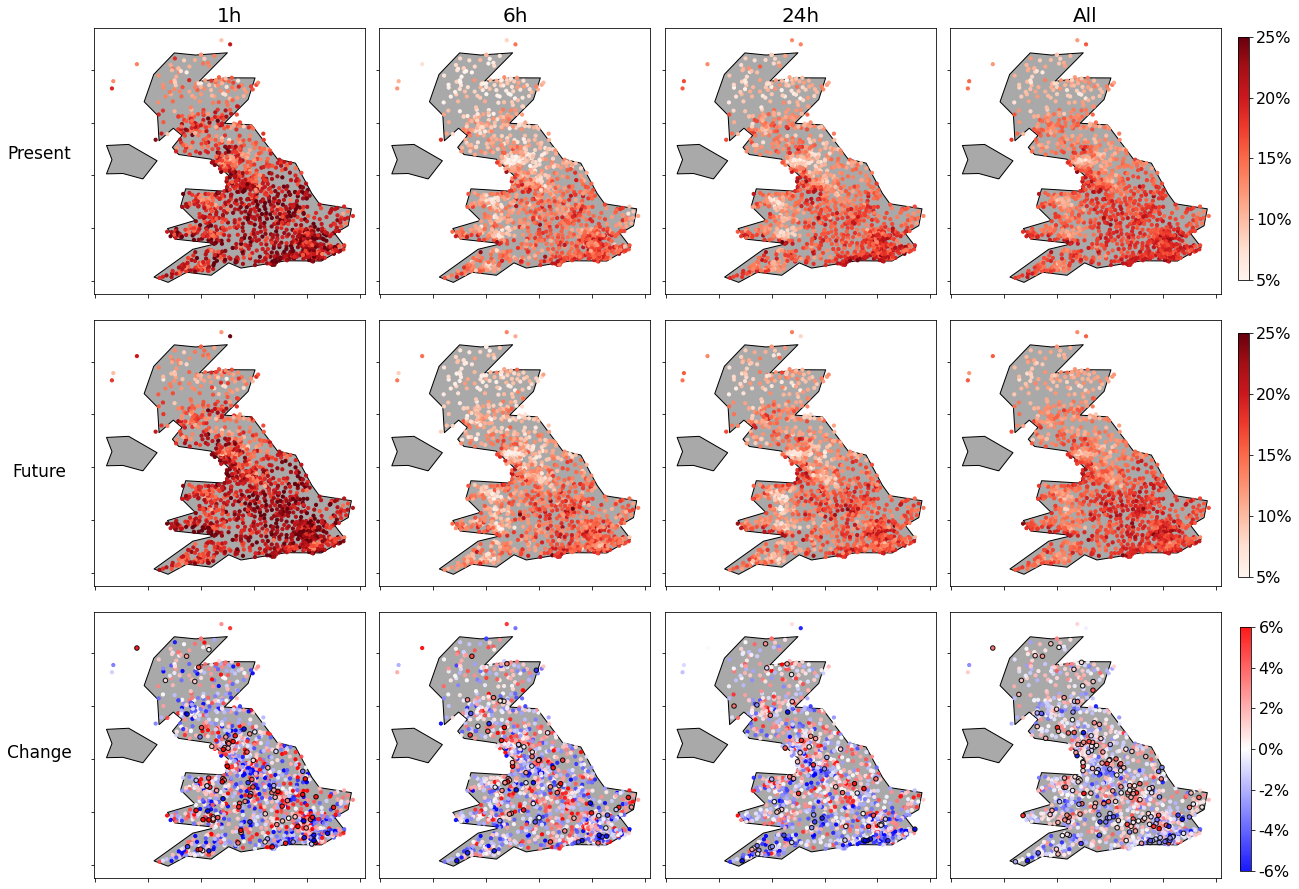

In [207]:
make_plot(df_changes_all, df_changes_byduration, 'B2_percentage', 'Reds', D50_diffs_dict, 5, 25) 

## Distribution of values

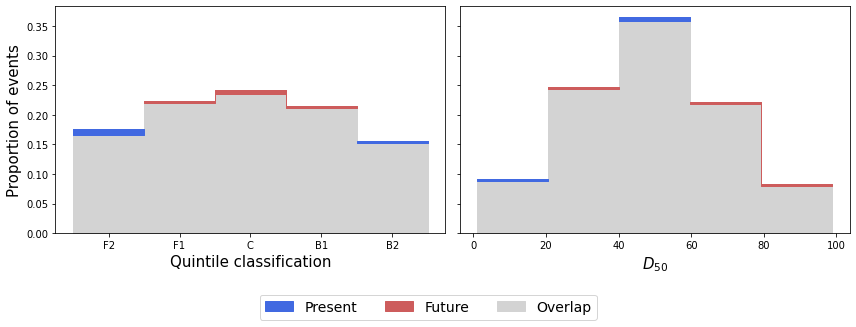

In [84]:
# Example usage with sample data
fig, axs = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

# Example bins
bins = 5

# Plot D50 histogram with overlap
plot_quintile_hist_with_overlap_shading(axs[1], present_all_events['D50_new'], future_all_events['D50_new'], bins=bins)
axs[1].set_xlabel("$D_{50}$", fontsize=15)
axs[0].set_ylabel('Proportion of events', fontsize=15)

# Repeat for max_quintile_molly
plot_quintile_hist_with_overlap_shading(axs[0], present_all_events['max_quintile_molly'], future_all_events['max_quintile_molly'], bins=bins)
axs[0].set_xlabel('Quintile classification', fontsize=15)

# Create custom legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
overlap_patch = mpatches.Patch(color='lightgrey', label='Overlap')
fig.legend(handles=[present_patch, future_patch, overlap_patch], loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=[0.5, -0.15])

# Calculate bin edges and centers for x-tick positioning
counts, bin_edges = np.histogram(present_all_events['max_quintile_molly'], bins=5)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
axs[0].set_xticks(bin_centers)
axs[0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

plt.tight_layout()
plt.show()


In [ ]:
# Define the duration categories
durations =['<4hr', '4-12hr','12hr+']

# Colors for the different histograms
colors = ['blue', 'cyan', 'gray', 'red']

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Adjust figure size

# Loop through each duration category
for ax_num, (duration, color) in enumerate(zip(durations, colors)):
    # Filter the data for this duration
    this_duration_present = present_all_events[present_all_events["DurationRange_simple"] == duration]
    less_than_50 = this_duration_present[this_duration_present['D50_new']<50]
    prop_less_than_50 = round(len(less_than_50)/len(this_duration_present) *100,1)
    print(prop_less_than_50)
    # Plot the histogram as a stepped line
    plt.hist(
        this_duration_present['D50_new'], 
        bins=100, 
        density=True, 
        histtype='step', 
        color=color, 
        linewidth=1.5, 
        label=duration
    )

# Add legend, labels, and grid
plt.xlabel('D50_new', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Stepped Histograms for Different Duration Categories', fontsize=14)
plt.legend(title='Duration Categories')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()


## Roberto style analysis

In [ ]:
# # Apply the function to the Age column using the apply() function
# present['D50_loading'] = present['D50'].apply(categorise_D50)
# future['D50_loading'] = future['D50'].apply(categorise_D50)

In [ ]:
# quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
# quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
# color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
#     'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

# my_dict = {'Present (UKCP18)' :present, 'Future (UKCP18)':future}
# short_ids = ['Present (UKCP18)', 'Future (UKCP18)']

# # Create the subplots
# fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# # Loop over each id and create the plots
# for i, id in enumerate(short_ids):
#     create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'Loading_profile_molly', 
#         quintile_cats, color_mapping,  short_ids[i])

In [ ]:
# quintile_mapping = {1: 'F', 2: 'B'}
# quintile_cats = ['F', 'B']
# color_mapping = {'F': (0.0, 0.0, 1.0, 0.6), 'B': (0.5451, 0.0, 0.0, 0.6)}

# # Create the subplots
# fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# # Loop over each id and create the plots
# for i, id in enumerate(short_ids):
#     create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'D50_loading', 
#         quintile_cats, color_mapping,  short_ids[i])

## Add version for different durations

## Comparing methods

In [ ]:
# df_long = df_long.sort_values('Loading_profile_molly')
# df_long = df_long.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

# present = present.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)
# future = future.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

In [ ]:
# quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
# quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
# color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
#     'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

# fig, axs = plt.subplots(figsize=(8,4))
# plot_boxplot(df_long[['Loading_profile_molly', 'D50']], axs, color_mapping)
# plt.show()

### With seasonal split

In [ ]:
# # Define custom order for Loading_profile_molly and season
# loading_order = ['F2', 'F1', 'C', 'B1', 'B2']
# season_order = [  'Spring', 'Summer', 'Autumn','Winter',]

# # Create a mapping for custom orders
# loading_mapping = {value: index for index, value in enumerate(loading_order)}
# season_mapping = {value: index for index, value in enumerate(season_order)}

# # Add new columns to the DataFrame for sorting
# present['Loading_order'] = present['Loading_profile_molly'].map(loading_mapping)
# present['Season_order'] = present['season'].map(season_mapping)

# # Sort the DataFrame by the new order columns
# present = present.sort_values(by=['Loading_order', 'Season_order'], ignore_index=True)

# # Drop the temporary sorting columns
# present = present.drop(columns=['Loading_order', 'Season_order'])

In [ ]:
# fig, axs = plt.subplots(figsize=(12,8))
# plot_boxplot_by_season(present[['Loading_profile_molly', 'D50', 'season']], axs)

### D50 vs Tb0

In [ ]:
df_merged = pd.merge(df_changes_all, tbo_vals[['gauge_num', 'Critical_interarrival_time', 'Lon', 'Lat']], on='gauge_num', how='left')

## D50 vs Day of year

In [ ]:
# variable = 'D50_P90'
# variable = 'D50_P10'

In [212]:
def make_scatter_plot(df, duration, timeperiod, loadings, axes, ax_row):
    df["D_mean_present"] = df["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
    df["D_mean_future"] = df["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)
    
    for ax_num, (loading, title) in enumerate(zip(loadings, loadings)):
        title = title if ax_row in[0,5] else ''
        
        if duration in [1, 6, 24]:
            this_duration = df[df['sampling_duration'] == float(duration)]
            make_point_density_plot(
                axes[ax_row][ax_num],  # Updated indexing
                this_duration[f"D_mean_{timeperiod}"],
                this_duration[f"{loading}_percentage_{timeperiod}"],
                title
            )
        else:
            make_point_density_plot(
                axes[ax_row][ax_num],  # Updated indexing
                df[f"D_mean_{timeperiod}"],
                df[f"{loading}_percentage_{timeperiod}"],
                title
            )

In [ ]:
def make_scatter_plot(df, duration, timeperiod, loadings, axes, ax_row):
    df["D_mean_present"] = df["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
    df["D_mean_future"] = df["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)
    
    for ax_num, (loading, title) in enumerate(zip(loadings, loadings)):
        title = title if ax_row in[0,5] else ''
        
        if duration in [1, 6, 24]:
            this_duration = df[df['sampling_duration'] == float(duration)]
            make_point_density_plot(
                axes[ax_row][ax_num],  # Updated indexing
                this_duration[f"D_mean_{timeperiod}"],
                this_duration[f"{loading}_percentage_{timeperiod}"],
                title
            )
        else:
            make_point_density_plot(
                axes[ax_row][ax_num],  # Updated indexing
                df[f"D_mean_{timeperiod}"],
                df[f"{loading}_percentage_{timeperiod}"],
                title
            )


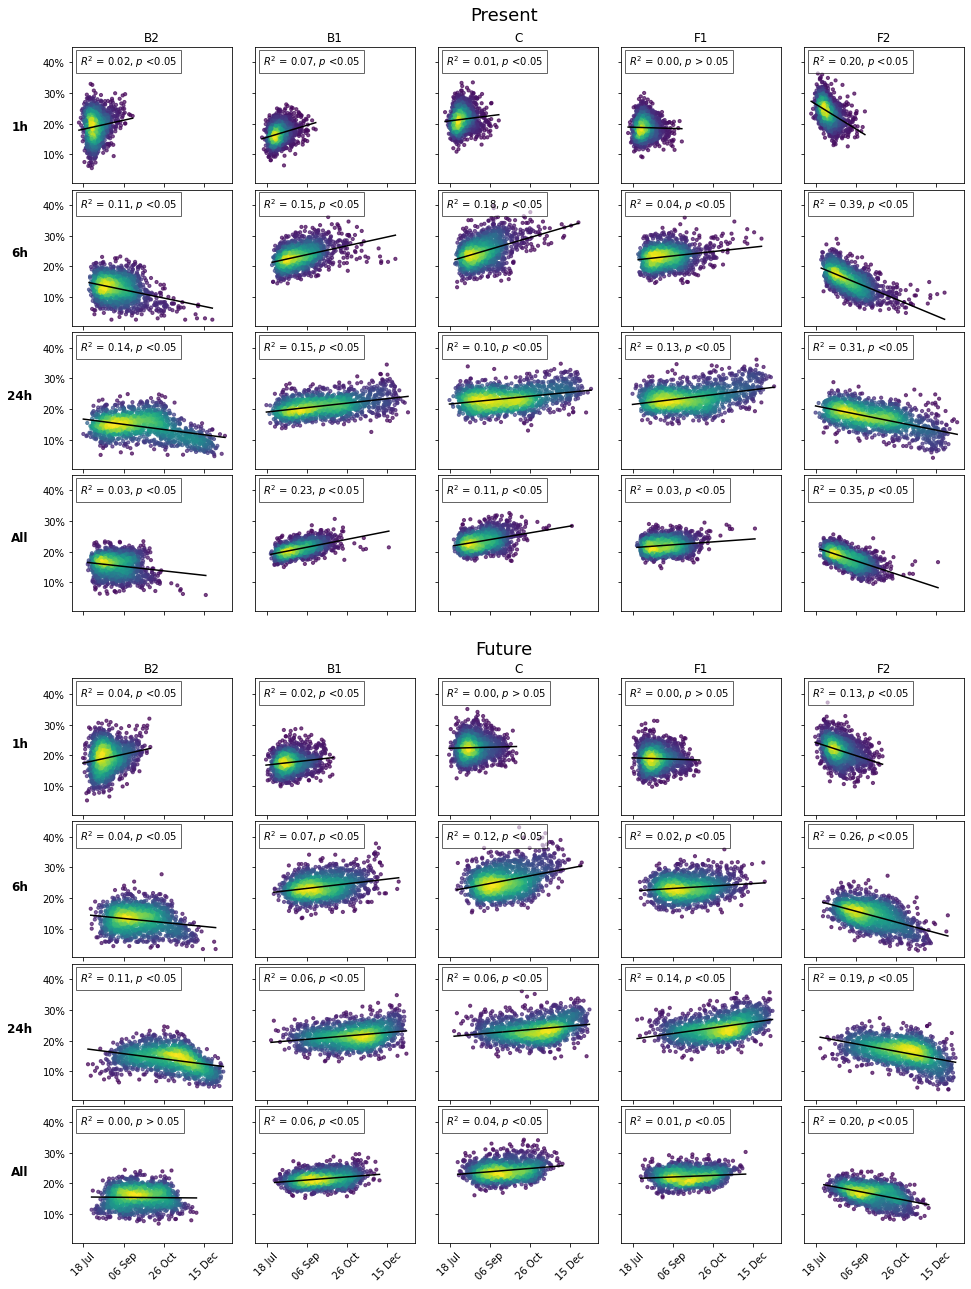

In [213]:
# Creating the axes layout
fig, axes = plt.subplots(
    9, 5, 
    figsize=(16, 22), 
    sharey='all', 
    sharex='all', 
    gridspec_kw={
        'hspace': 0.05, 
        'wspace': 0.14, 
        'height_ratios': [1, 1, 1, 1, 0.4, 1, 1, 1, 1]})

for ax_row in axes:
    for ax in ax_row:
        if ax is not None:  # Ensure the axis exists
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

loadings =['B2', 'B1', 'C', 'F1', 'F2']

# Call the function
make_scatter_plot(df_changes_byduration_cat2.copy(), 1, "present", loadings, axes, ax_row=0)
make_scatter_plot(df_changes_byduration_cat2.copy(), 6, "present", loadings, axes, ax_row=1)
make_scatter_plot(df_changes_byduration_cat2.copy(), 24, "present", loadings, axes, ax_row=2)
make_scatter_plot(df_changes_all.copy(), 'All', "present", loadings, axes, ax_row=3)
fig.text(0.5, 0.9, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal')

fig.text(0.08, 0.83, '1h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.75, '6h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.66, '24h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.57, 'All', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')

for ax in axes[4]:
    ax.axis("off")

make_scatter_plot(df_changes_byduration.copy(), 1, "future", loadings, axes, ax_row=5)
make_scatter_plot(df_changes_byduration.copy(), 6, "future", loadings, axes, ax_row=6)
make_scatter_plot(df_changes_byduration.copy(), 24, "future", loadings, axes, ax_row=7)
make_scatter_plot(df_changes_all.copy(), 'All', "future", loadings, axes, ax_row=8)
fig.text(0.5, 0.5, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal')

fig.text(0.08, 0.44, '1h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.35, '6h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.26, '24h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.17, 'All', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')


# After plotting, convert Julian day ticks to calendar dates
for ax in axes.flatten():
    if ax is not None:  # In case of unused subplots
        # Get the current axis limits
        x_min, x_max = ax.get_xlim()
        
        # Restrict ticks to the visible range
        ticks = ax.get_xticks()
        visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

        # Convert the visible ticks to date labels
        tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]
        # Apply the visible ticks and corresponding labels
        ax.set_xticks(visible_ticks)  # Restrict ticks to the visible range
        ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
        ax.tick_params(axis='x', rotation=45)  # Rotate labels for better visibility

plt.show()

## Plot contour plot of all events against the day of year they occurred

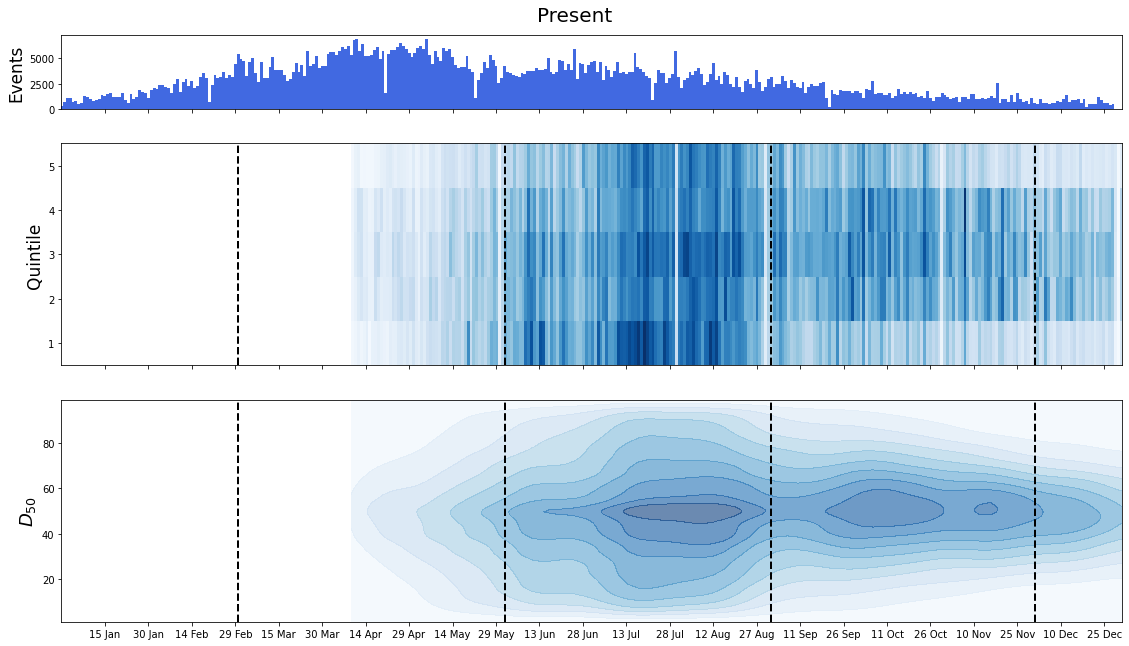

In [14]:
from datetime import datetime
fig, axs = plt.subplots(nrows = 3,  figsize=(19, 10), sharex=True, gridspec_kw={'height_ratios': [1, 3,3]})
fig.suptitle("Present", fontsize=20)
fig.subplots_adjust(top=0.94)

df = present_all_events

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='royalblue', linewidth=2, width=1)

# # Set labels
axs[0].set_ylabel('Events', fontsize=17);
axs[1].set_ylabel("Quintile", fontsize=17);

# Set bins to align with the y-axis discrete values
y_bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Bins centered around 1, 2, 3, 4, 5
x_bins = 365  # You can keep this as a default for x-axis

# Create the 2D histogram
hist, x_edges, y_edges, _ = axs[1].hist2d(
    df['D'], 
    df['max_quintile_molly'], 
    bins=[x_bins, y_bins],  # Use custom y_bins
    cmap='Blues'
)

plot_contour_all_events(axs[2], df['D'], df['D50_new'], 'Blues')

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[2].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[2].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[2].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[2].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=25))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

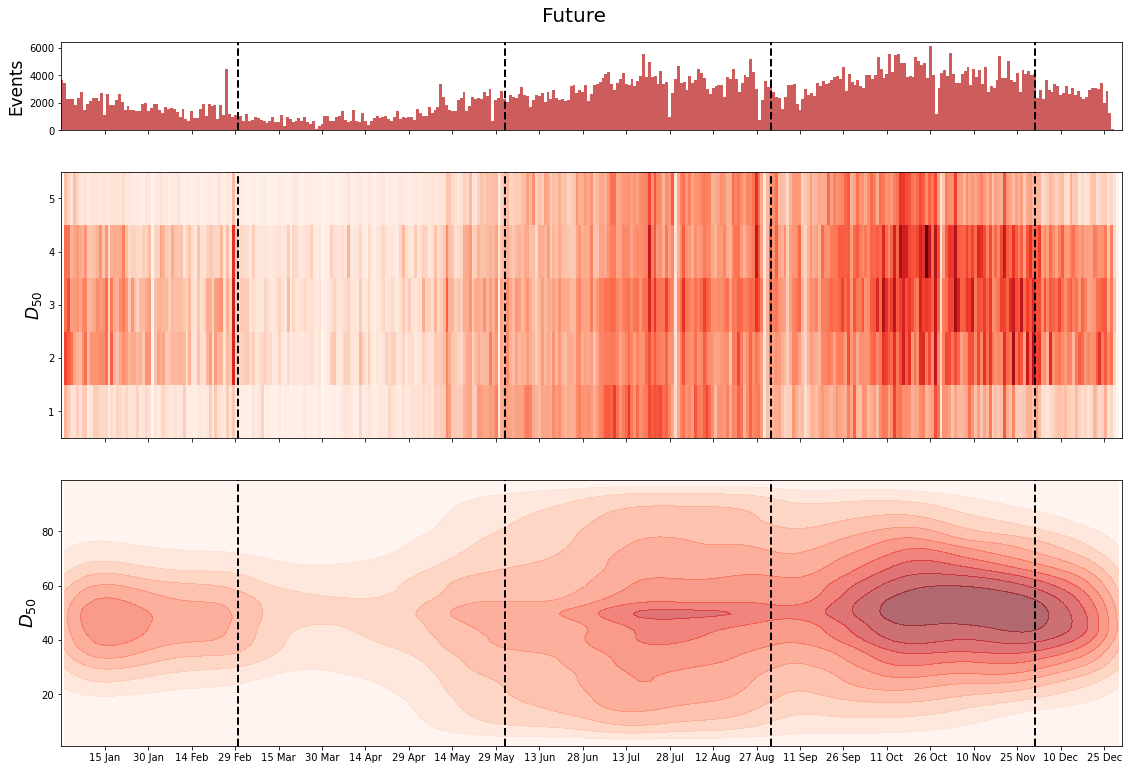

In [226]:
fig, axs = plt.subplots(nrows = 3,  figsize=(19, 12), sharex=True, gridspec_kw={'height_ratios': [1, 3,3]})
fig.suptitle("Future", fontsize=20)
fig.subplots_adjust(top=0.94)

df = future_all_events

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

# Set bins to align with the y-axis discrete values
y_bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Bins centered around 1, 2, 3, 4, 5
x_bins = 365  # You can keep this as a default for x-axis

# Create the 2D histogram
hist, x_edges, y_edges, _ = axs[1].hist2d(
    df['D'], 
    df['max_quintile_molly'], 
    bins=[x_bins, y_bins],  # Use custom y_bins
    cmap='Reds'
)

plot_contour_all_events(axs[2], df['D'], df['D50_new'], 'Reds' )

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")

# After plotting your figure, you can add a vertical line to axs[1]
# After plotting your figure, you can add a vertical line to axs[1]
axs[0].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[0].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[0].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[0].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[2].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[2].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[2].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[2].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=25))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

## Another option: 